In [188]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed
plt.style.use('fivethirtyeight')

%matplotlib inline

pd.set_option('display.expand_frame_repr', False)
plt.rcParams['figure.figsize'] = (20, 10)

In [176]:
data = pd.read_excel('nasdaq.xlsx')
data.tail(25)

,Date,Open,High,Low,Close,Adj Close,Volume
1239,2020-10-30,11103.469727,11129.809570,10822.570313,10911.589844,10911.589844,3.662840e+09
1240,2020-11-02,11010.450195,11071.080078,10830.950195,10957.610352,10957.610352,3.196720e+09
1241,2020-11-03,11038.660156,11213.919922,11004.839844,11160.570313,11160.570313,3.190710e+09
1242,2020-11-04,11443.769531,11663.309570,11394.209961,11590.780273,11590.780273,3.606820e+09
1243,2020-11-05,11816.330078,11924.280273,11784.150391,11890.929688,11890.929688,3.823380e+09
1244,2020-11-06,11869.900391,11920.540039,11737.129883,11895.230469,11895.230469,4.156030e+09
1245,2020-11-09,12046.660156,12108.070313,11703.490234,11713.780273,11713.780273,5.823620e+09
1246,2020-11-10,11622.440430,11665.870117,11424.610352,11553.860352,11553.860352,4.712950e+09
1247,2020-11-11,11656.650391,11793.570313,11638.900391,11786.429688,11786.429688,3.823270e+09
1248,2020-11-12,11802.500000,11847.839844,11666.370117,11709.589844,11709.589844,3.862690e+09


In [157]:
data = data.iloc[:, [0, 4]]
data.columns = ['Date', 'Close']
data

,Date,Close
0,2015-11-30,5108.669922
1,2015-12-01,5156.310059
2,2015-12-02,5123.220215
3,2015-12-03,5037.529785
4,2015-12-04,5142.270020
...,...,...
1259,2020-12-14,NaN
1260,2020-12-15,NaN
1261,2020-12-16,NaN
1262,2020-12-17,NaN


In [159]:
'''
data = data.assign(year=lambda x : x['Date'].str[0:4],
                   month=lambda x : x['Date'].str[5:7],
                   day=lambda x : x['Date'].str[8:10]
                  )
data = data.assign(season=lambda x : (x['month'].astype(int)%12+3)//3)
data['Date'] = data["Date"].astype("datetime64")
data['year'] = data['year'].astype('category')
data['month'] = data['month'].astype('category')
data['day'] = data['day'].astype('category')
data['season'] = data['season'].astype('category')
'''

data = data.set_index(data['Date'])
del data['Date']
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1264 entries, 2015-11-30 to 2020-12-18
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1259 non-null   float64
dtypes: float64(1)
memory usage: 19.8 KB


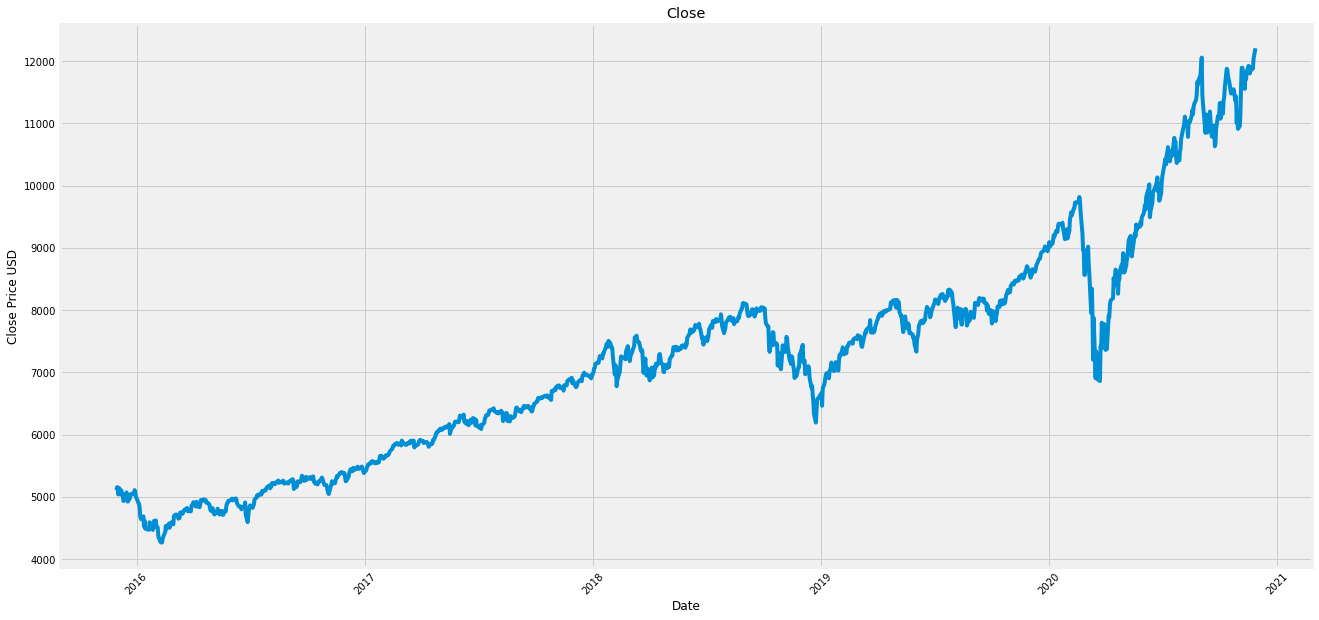

In [160]:
plt.title("Close")
plt.plot(data['Close'])
plt.xlabel("Date")
plt.xticks(rotation = 45)
plt.ylabel("Close Price USD")
plt.show()

In [161]:
close_data = data.filter(['Close'])
dataset = close_data.values # convert numpy.array
training_data_len = math.ceil(len(dataset)*.8)

training_data_len

1012

In [162]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

len(scaled_data)

1264

In [164]:
train_data = scaled_data[0:training_data_len]
x_train = []
y_train = []

for i in range(28, len(train_data)):
    x_train.append(train_data[i-28:i, 0])
    y_train.append(train_data[i, 0])
    if i <= 7 :
        print(x_train)
        print(y_train)
        print('----------------------Partition line----------------------')

In [165]:
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(984, 28, 1)

In [190]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [191]:
model.compile(optimizer = 'adam', loss='mean_squared_error')

In [192]:
model.fit(x_train, y_train, batch_size=1, epochs=10)

Epoch 1/10
984/984 [==============================] - 3s 3ms/step - loss: 0.0046
Epoch 2/10
984/984 [==============================] - 3s 3ms/step - loss: 0.0014
Epoch 3/10
984/984 [==============================] - 3s 3ms/step - loss: 0.0011
Epoch 4/10
984/984 [==============================] - 3s 3ms/step - loss: 9.7132e-04
Epoch 5/10
984/984 [==============================] - 3s 3ms/step - loss: 9.3174e-04
Epoch 6/10
984/984 [==============================] - 3s 3ms/step - loss: 9.1196e-04
Epoch 7/10
984/984 [==============================] - 3s 3ms/step - loss: 9.2911e-04
Epoch 8/10
984/984 [==============================] - 3s 3ms/step - loss: 9.0226e-04
Epoch 9/10
984/984 [==============================] - 3s 3ms/step - loss: 8.9788e-04
Epoch 10/10
984/984 [==============================] - 3s 3ms/step - loss: 8.9428e-04


In [180]:
test_data = scaled_data[training_data_len - 28 : , :]

x_test = []
y_test = dataset[training_data_len :, :]
for i in range(28, len(test_data)) :
    x_test.append(test_data[i-28:i, 0])

In [193]:
x_test = np.array(x_test)

x_test.shape

(252, 28, 1)

In [194]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [195]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

ValueError: Found array with dim 3. Estimator expected <= 2.

In [184]:
rmse = np.sqrt(np.mean(((predictions-y_test)**2)))
rmse

nan

In [185]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
plt.title('LSTM Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Validation', 'Predictions'], loc = 'upper left')
plt.show()

ValueError: Wrong number of items passed 5, placement implies 1

In [175]:
valid

,Close,Predictions
Date,,
2019-12-06,8656.530273,8334.940430
2019-12-09,8621.830078,8417.668945
2019-12-10,8616.179688,8380.910156
2019-12-11,8654.049805,8381.432617
2019-12-12,8717.320313,8416.589844
...,...,...
2020-12-14,NaN,11628.230469
2020-12-15,NaN,NaN
2020-12-16,NaN,NaN
